In [1]:
import torch
import glob
import os
from PIL import Image
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.preprocessing import normalize
import keras
from keras.utils import normalize, to_categorical
from sklearn.preprocessing import LabelEncoder
import segmentation_models as sm
import tensorflow as tf

Segmentation Models: using `keras` framework.


In [2]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, test = False):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','*.png'))
        self.mask_files = []
        self.img = []
        self.mask = []
        self.test = test
        
        if not self.test:
            for img_path in self.img_files:
                self.mask_files.append(os.path.join(folder_path,'labels',os.path.basename(img_path.split(".")[0] + "_Annotation.png"))) 
        

    def __getall__(self):
        for each in self.img_files:
            self.img.append(normalize(cv2.resize(cv2.imread(each, cv2.IMREAD_COLOR), (512,512)), axis = 1))
        if not self.test:
            for each in self.mask_files:
                self.mask.append(cv2.resize(cv2.imread(each, 0), (512,512)))
            return (np.array(self.img)) , (np.array(self.mask))
        else:
            return (np.array(self.img)), self.img_files

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_COLOR)
            label = cv2.imread(mask_path, 0)
            label = to_categorical(label, 6)
            return torch.from_numpy(data).float().permute(2,0,1), torch.from_numpy(label).float().permute(2,0,1)

    def __len__(self):
        return len(self.img_files)

In [3]:
test_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\test", test = True)
val_dataset =  DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\val")
val_images, val_masks = val_dataset.__getall__()
test_images, img_path = test_dataset.__getall__()

In [4]:
print(test_images.shape)

(13, 512, 512, 3)


# Model

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

# Test

In [6]:
model_pretrained = ["unet_on_RBG_and_categorical_cross.hdf5", "unet_on_RGB_with_dice_and_focal.hdf5", "unet_on_RGB_with_dice_and_focal_with_class_weights_batch_8.hdf5", "unet_on_RGB_with_dice_and_focal_with_class_weights_batch_8_epoch_200_with_earlystopping.hdf5", ""]
#unet_on_RGB_with_dice_and_focal_with_class_weights_batch_8_epoch_200_with_earlystopping.hdf5 performed quite well,in comparision to other models
IMG_HEIGHT = test_images.shape[1]
IMG_WIDTH  = test_images.shape[2]
IMG_CHANNELS = test_images.shape[3]
n_classes = 6
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model = tf.keras.models.load_model(model_pretrained[3], compile = False)

512 512 3


Saving predictions in the test_pred folder

In [7]:
y_pred=model.predict(test_images)
print(y_pred.shape)

(13, 512, 512, 6)


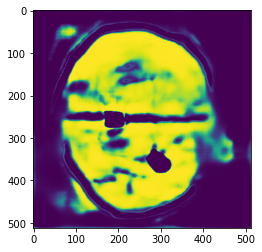

In [8]:
for i in range(y_pred.shape[0]):
    for j in range(6):
        plt.imshow(y_pred[i, :, :, j])
        plt.savefig("test_pred/"+img_path[i].split("images\\")[1].split(".")[0]+"_class_"+str(j)+"_prediction.png")

Comparing validation ground truth values with validation predictions

In [9]:
y_pred=model.predict(val_images)

In [10]:
val_masks_cat = (to_categorical(val_masks, num_classes = 6))

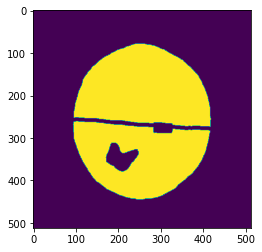

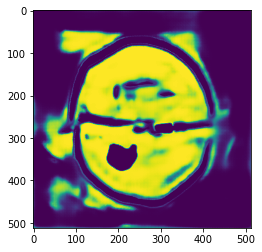

In [11]:
i = 0
j = 5
plt.imshow(val_masks_cat[i,:,:,j])
plt.show()
plt.imshow(y_pred[i,:,:,j])
plt.show()

In [12]:
import keras.backend as K
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average
    
# IOU metric

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [13]:
y_pred=model.predict(val_images)
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For val and pred, dice score =  {dice_score}')
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')

For val and pred, dice score =  0.717540555990638
For A and B 0.7068813443183899


Other variants of UNet

Resnet

In [14]:
model_pretrained_resnet = ["unet_with_resnet_backbone_with_dice_and_focal_batch_4.hdf5","unet_with_resnet_backbone.hdf5"]
#unet_with_resnet_backbone.hdf5 (batch size 8) performed better but overall, both didn't converge
n_classes=6
activation='softmax'
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_val = preprocess_input1(val_images)
X_test = preprocess_input1(test_images)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1 = tf.keras.models.load_model(model_pretrained_resnet[0], compile = False)

In [15]:
y_pred=model1.predict(X_test)
print(y_pred.shape)

(13, 512, 512, 6)


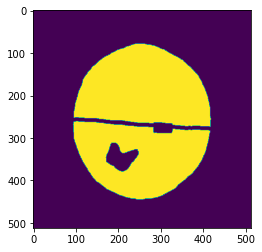

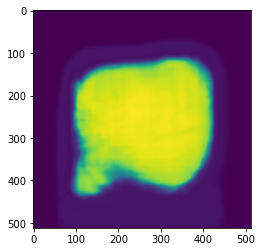

In [16]:
y_pred=model1.predict(X_val)
i = 0
j = 5
plt.imshow(val_masks_cat[i,:,:,j])
plt.show()
plt.imshow(y_pred[i,:,:,j])
plt.show()

In [17]:
y_pred=model1.predict(X_val)
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For val and pred, dice score =  {dice_score}')
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')

For val and pred, dice score =  0.24689662772728052
For A and B 0.4163840711116791


Inception

In [18]:
model_pretrained_inception = ["unet_with_inception_backbone_with_dice_and_focal_batch_4.hdf5","unet_with_inception_backbone_with_dice_and_focal.hdf5"]
#unet_with_inception_backbone_with_dice_and_focal.hdf5 (batch size 8) performed better but overall, both didn't converge
n_classes=6
activation='softmax'

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_val = preprocess_input2(val_images)
X_test = preprocess_input2(test_images)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

model2 = tf.keras.models.load_model(model_pretrained_inception[1], compile = False)

In [19]:
y_pred=model2.predict(X_test)
print(y_pred.shape)

(13, 512, 512, 6)


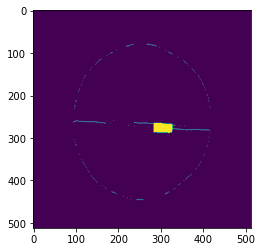

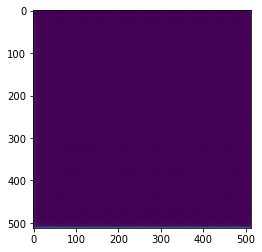

In [20]:
y_pred=model2.predict(X_val)
i = 0
j = 3
plt.imshow(val_masks_cat[i,:,:,j])
plt.show()
plt.imshow(y_pred[i,:,:,j])
plt.show()

In [21]:
y_pred=model2.predict(X_val)
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For val and pred, dice score =  {dice_score}')
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')

For val and pred, dice score =  0.1518352527529693
For A and B 0.3897760510444641


VGG16

In [22]:
model_pretrained_vgg16 = ["unet_with_vgg16_backbone_with_dice_and_focal_batch_4.hdf5","unet_with_vgg16_backbone_with_dice_and_focal_batch_8.hdf5"]
#unet_with_vgg16_backbone_with_dice_and_focal_batch_8.hdf5 (batch size 8) performed better but overall, both didn't converge
n_classes=6
activation='softmax'
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_val = preprocess_input2(val_images)
X_test = preprocess_input2(test_images)

# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)
model3 = tf.keras.models.load_model(model_pretrained_vgg16[1], compile = False)

In [23]:
y_pred=model3.predict(X_test)
print(y_pred.shape)

(13, 512, 512, 6)


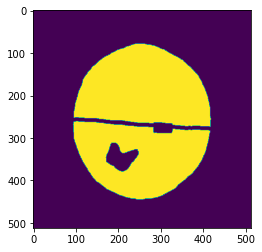

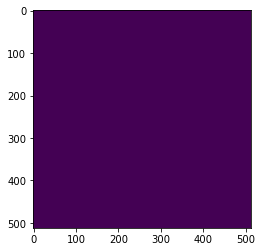

In [24]:
y_pred=model3.predict(X_val)
i = 0
j = 5
plt.imshow(val_masks_cat[i,:,:,j])
plt.show()
plt.imshow(y_pred[i,:,:,j])
plt.show()

In [25]:
y_pred=model3.predict(X_val)
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For val and pred, dice score =  {dice_score}')
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')

For val and pred, dice score =  0.015083958184427433
For A and B 0.023409053683280945
